In [1]:
import numpy as np

from rocketpy import Environment, Flight, Function, Rocket, MonteCarlo, SolidMotor, utilities
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticFlight,
    StochasticParachute,
    StochasticRocket,
    StochasticSolidMotor,
)

In [37]:
ROCKET_LENGTH = 3.73

parameters = {
    # Mass Details
    "rocket_mass": 21390 / 1000,  # propellant mass = 1.37
    "CG": -2.49,

    # Aerodynamic Details
    "inertia_i": 0.968,
    "inertia_z": 0.014,
    "radius": 157 / 2000,
    "nozzle_dist_from_tip": -ROCKET_LENGTH,
    "power_off_drag": "./CD_Mach.csv",
    "power_on_drag": "./CD_Mach.csv",
    "nose_length": 0.838,
    "nfins": 4,
    "fin_thickness": 13 / 1000,
    "fin_dist_from_tip": -ROCKET_LENGTH + 0.4314,

    # Launch and Environment Details
    "wind_direction": 0,
    "wind_speed": 2,
    "inclination": 90, # Relative to ground
    "heading": 45,
    "rail_length": 12,

    # Parachute Details
    "CdS_drogue": 1.16,
    "CdS_main": 2.92,
    "lag_rec": 2, # Lag between chute deployment and inflation,
    "main_deploy_alt": 500
}

In [38]:
# Environment conditions
env = Environment(
    latitude=39.078542,
    longitude=-75.876347, # Higgs
    date=(2025, 12, 13, 12),
    elevation=17,
)
env.set_atmospheric_model(type="Ensemble", file="GEFS")

env.max_expected_height = 2000

oc_open: server error retrieving url: code=0 message="/gens_bc/gens20251208/gep_all_06z is not an available dataset"


Gravity Details

Acceleration of gravity at surface level:    9.8008 m/s²
Acceleration of gravity at   2.000 km (ASL): 9.7947 m/s²


Launch Site Details

Launch Date: 2025-12-13 12:00:00 UTC
Launch Site Latitude: 39.07854°
Launch Site Longitude: -75.87635°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 424198.93 W    4325857.98 N
Launch Site UTM zone: 17S
Launch Site Surface Elevation: 17.0 m


Atmospheric Model Details

Atmospheric Model Type: Ensemble
Ensemble Maximum Height: 2.000 km
Ensemble Time Period: from 2025-12-08 00:00:00 to 2025-12-24 00:00:00 utc
Ensemble Hour Interval: 6 hrs
Ensemble Latitude Range: From -90.0° to 90.0°
Ensemble Longitude Range: From 0.0° to 359.5°
Number of Ensemble Members: 31
Selected Ensemble Member: 0 (Starts from 0)


Surface Atmospheric Conditions

Surface Wind Speed: 16.16 m/s
Surface Wind Direction: 294.11°
Surface Wind Heading: 114.11°
Surface Pressure: 1000.00 hPa
Surface Temperature: 267.54 K
Surface Air Density: 1.302 kg/m³
Surface

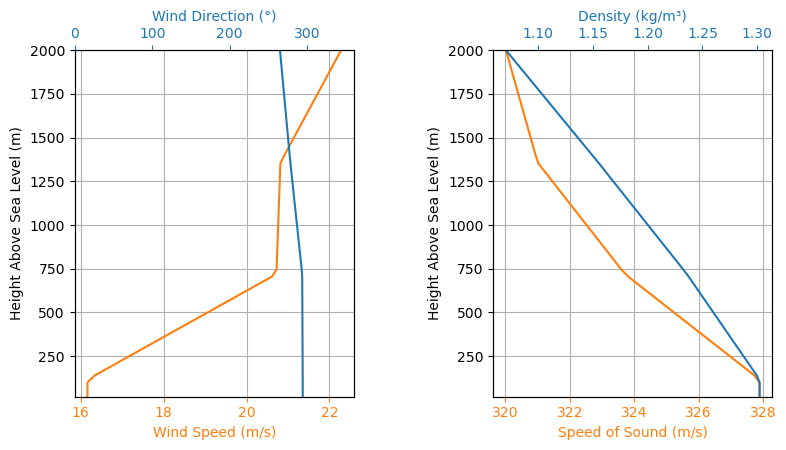

In [39]:
env.info()

In [40]:
L1520 = SolidMotor(
    thrust_source="AeroTech_L1520T.eng",
    dry_mass=1.797,
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=0.22,
    grains_center_of_mass_position=0.22,
    grain_number=3,
    grain_separation=1.5 / 1000,
    grain_density=1625, # Blue Thunder
    grain_outer_radius=65 / 2000,
    grain_initial_inner_radius=22.225 / 2000,
    grain_initial_height=131.7752 / 1000,
    nozzle_radius=30 / 2000,
    throat_radius=18.26 / 2000,
    interpolation_method="linear",
    nozzle_position=0,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

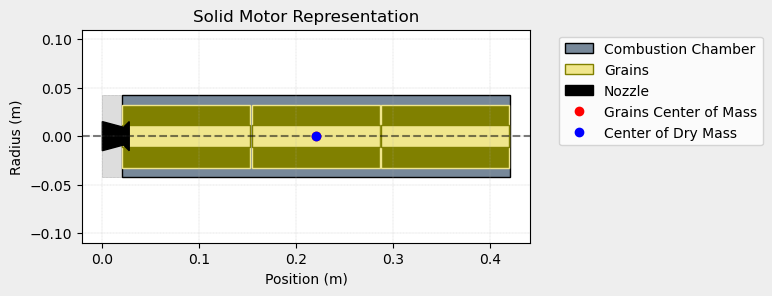

In [41]:
L1520.plots.draw()

Nozzle Details
Nozzle Radius: 0.015 m
Nozzle Throat Radius: 0.009130000000000001 m

Grain Details
Number of Grains: 3
Grain Spacing: 0.0015 m
Grain Density: 1625 kg/m3
Grain Outer Radius: 0.0325 m
Grain Inner Radius: 0.0111125 m
Grain Height: 0.1317752 m
Grain Volume: 0.000 m3
Grain Mass: 0.627 kg

Motor Details
Total Burning Time: 2.6 s
Total Propellant Mass: 1.882 kg
Structural Mass Ratio: 0.488
Average Propellant Exhaust Velocity: 2002.150 m/s
Average Thrust: 1449.614 N
Maximum Thrust: 1696.632 N at 1.1 s after ignition.
Total Impulse: 3768.996 Ns



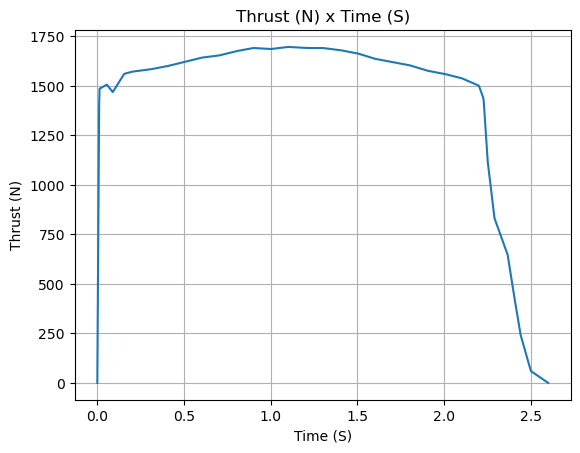

In [42]:
L1520.info()

In [43]:
FinnMcMissile = Rocket(
    radius=parameters.get("radius"),
    mass=parameters.get("rocket_mass"),
    inertia=(
        parameters.get("inertia_i"),
        parameters.get("inertia_i"),
        parameters.get("inertia_z"),
    ),
    power_off_drag=parameters.get("power_off_drag"),
    power_on_drag=parameters.get("power_on_drag"),
    center_of_mass_without_motor=parameters.get("CG"),
)
FinnMcMissile.set_rail_buttons(-ROCKET_LENGTH + 0.813, -ROCKET_LENGTH + 0.813 - 0.762)
FinnMcMissile.add_motor(motor=L1520, position=parameters.get("nozzle_dist_from_tip"))

In [44]:
nose_cone = FinnMcMissile.add_nose(
    length=parameters.get("nose_length"),
    kind="von karman",
    position=0,
)

fin_set = FinnMcMissile.add_trapezoidal_fins(
    parameters.get("nfins"),
    span = 20.3 / 100,
    sweep_length = 27.9 / 100,
    root_chord = 40.6 / 100,
    tip_chord = 12.7 / 100,
    position=parameters.get("fin_dist_from_tip"),
)

In [45]:
drogue = FinnMcMissile.add_parachute(
    "Drogue",
    cd_s=parameters.get("CdS_drogue"),
    trigger="apogee",
    lag=parameters.get("lag_rec"),
)

main = FinnMcMissile.add_parachute(
    "Main",
    cd_s=parameters.get("CdS_main"),
    trigger=parameters.get("main_deploy_alt"),
    lag=parameters.get("lag_rec"),
)

In [46]:
# airbrake = FinnMcMissile.add_air_brakes(
#     drag_coefficient_curve="./air_brake_cd.csv",
#     controller_function=controller_function,
#     sampling_rate=10,
#     reference_area=None,
#     clamp=True,
#     initial_observed_variables=[0, 0, 0],
#     override_rocket_drag=False,
#     name="Airbrake",
# )

# airbrake.all_info()

In [47]:
FinnMcMissile.info()


Inertia Details

Rocket Mass: 21.390 kg (without motor)
Rocket Dry Mass: 23.187 kg (with unloaded motor)
Rocket Loaded Mass: 25.069 kg
Rocket Structural Mass Ratio: 0.925
Rocket Inertia (with unloaded motor) 11: 2.693 kg*m2
Rocket Inertia (with unloaded motor) 22: 2.693 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.014 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0785 m
Rocket Frontal Area: 0.019359 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.079 m
Rocket Center of Dry Mass - Nozzle Exit: 1.161 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.941 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.071 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 14.485/rad

Center of Pressure

No

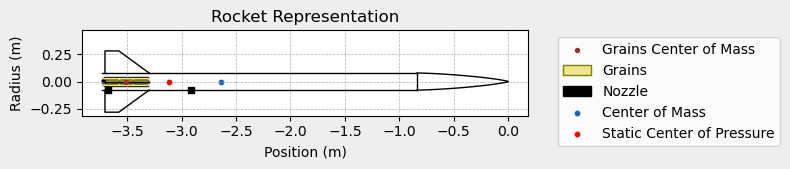

In [48]:
FinnMcMissile.draw()

In [49]:
# Flight
test_flight = Flight(
    rocket=FinnMcMissile,
    environment=env,
    rail_length=parameters.get("rail_length"),
    inclination=parameters.get("inclination"),
    heading=parameters.get("heading")
)


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 17.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 1.000 | e1: 0.000 | e2: 0.000 | e3: 0.000
Euler Angles - Spin φ : -180.00° | Nutation θ: 0.00° | Precession ψ: 180.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 3.024 c


Surface Wind Conditions

Frontal Surface Wind Speed: 5.76 m/s
Lateral Surface Wind Speed: -15.10 m/s


Launch Rail

Launch Rail Length: 12 m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 45.00°


Rail Departure State

Rail Departure Time: 0.659 s
Rail Departure Velocity: 35.088 m/s
Rail Departure Stability Margin: 3.143 c
Rail Departure Angle of Attack: 24.735°
Rail Departure Thrust-Weight Ratio: 6.847
Rail Departure Reynolds Number: 4.678e+05


Burn out State

Burn out time: 2.600 s
Altitude at burn out: 192.271 m (ASL) | 175.271 m (AGL)
Rocket speed at burn out: 123.652 m/s
Freestream velo

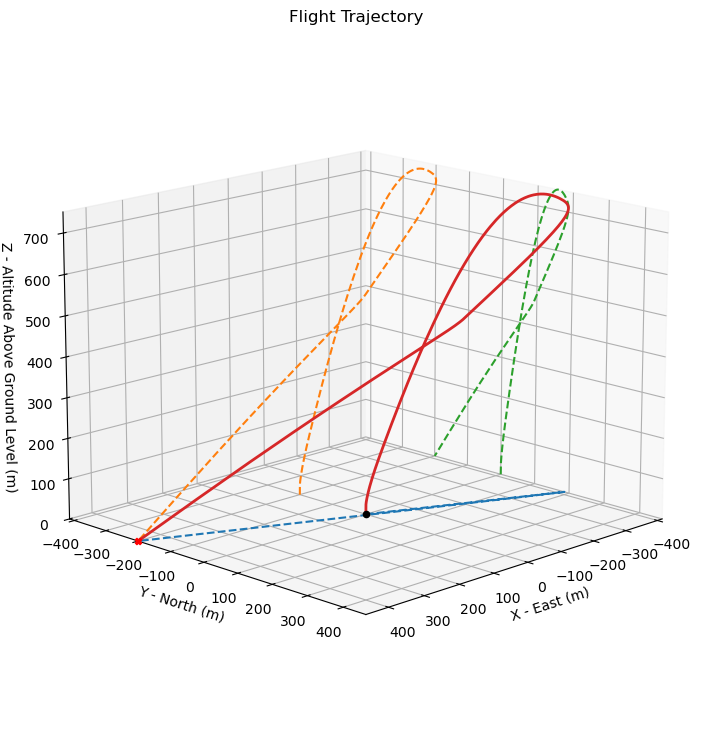

In [50]:
test_flight.info()
test_flight.plots.trajectory_3d()

In [51]:
# utilities.fin_flutter_analysis(parameters.get("fin_thickness"), 19000, test_flight, see_prints=True, see_graphs=True)

In [52]:
stochastic_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                17
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 39.078542
	longitude                -75.876347
	timezone                 UTC

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)

Stochastic Attributes with choice of values:
	ensemble_member [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [53]:
stochastic_compmotor = StochasticSolidMotor(
    solid_motor=L1520,
    grains_center_of_mass_position=0.001,
    grain_density=100,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=100,
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)

stochastic_compmotor.visualize_attributes()

Reporting the attributes of the `StochasticSolidMotor` object:

Constant Attributes:
	burn_out_time                    2.6
	burn_start_time                  0.0
	center_of_dry_mass_position      0.22
	coordinate_system_orientation    nozzle_to_combustion_chamber
	dry_I_11                         0
	dry_I_12                         0
	dry_I_13                         0
	dry_I_22                         0
	dry_I_23                         0
	dry_I_33                         0
	dry_mass                         1.797
	grain_number                     3
	interpolate                      linear
	thrust_source                    [[0, 0], [0.011, 1484.553], [0.055, 1506.304], [0.089, 1468.239], [0.155, 1560.684], [0.2, 1571.559], [0.3, 1582.435], [0.4, 1598.749], [0.5, 1620.501], [0.6, 1642.252], [0.7, 1653.128], [0.8, 1674.88], [0.9, 1691.194], [1.0, 1685.756], [1.1, 1696.632], [1.2, 1691.194], [1.3, 1691.194], [1.4, 1680.318], [1.5, 1664.004], [1.6, 1636.814], [1.7, 1620.501], [1.8, 1604.187

In [54]:
stochastic_rocket = StochasticRocket(
    rocket=FinnMcMissile,
    mass=1,
    inertia_11=0.1,
    inertia_22=0.1,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)

stochastic_main = StochasticParachute(
    parachute=main,
    cd_s=0.1,
    lag=0.1,
)

stochastic_drogue = StochasticParachute(
    parachute=drogue,
    cd_s=0.05,
    lag=0.2,
)

stochastic_rocket.add_motor(stochastic_compmotor, position=0.001)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)

stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)
	radius                          0.0785

Stochastic Attributes:
	I_11_without_motor              0.96800 ± 0.10000 (normal)
	I_22_without_motor              0.96800 ± 0.10000 (normal)
	I_33_without_motor              0.01400 ± 0.01000 (normal)
	center_of_mass_without_motor    -2.49000 ± 0.00000 (normal)
	mass                            21.39000 ± 1.00000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)


In [55]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=1,
    heading=2,
)
stochastic_flight.visualize_attributes()

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           12

Stochastic Attributes:
	heading               45.00000 ± 2.00000 (normal)
	inclination           90.00000 ± 1.00000 (normal)


In [56]:
test_dispersion = MonteCarlo(
    filename="FinnMcMissile_monte_carlo",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

test_dispersion.simulate(
    number_of_simulations=500,
    parallel=True,
    n_workers=64,
)

The following input file was imported: FinnMcMissile_monte_carlo.inputs.txt
A total of 0 simulations results were loaded from the following output file: FinnMcMissile_monte_carlo.outputs.txt

The following error file was imported: FinnMcMissile_monte_carlo.errors.txt                                        
Starting Monte Carlo analysis                                              
Running Monte Carlo simulation with 64 workers.


/home/space/micromamba/envs/rocketry/lib/python3.13/site-packages/rocketpy/simulation/monte_carlo.py:137: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


Current iteration: 000499 | Average Time per Iteration: 0.004 s | Estimated time left: 0 s
Completed 500 iterations. In total, 500 simulations are exported.
Total wall time: 2.0 s  
Results saved to FinnMcMissile_monte_carlo.outputs.txt


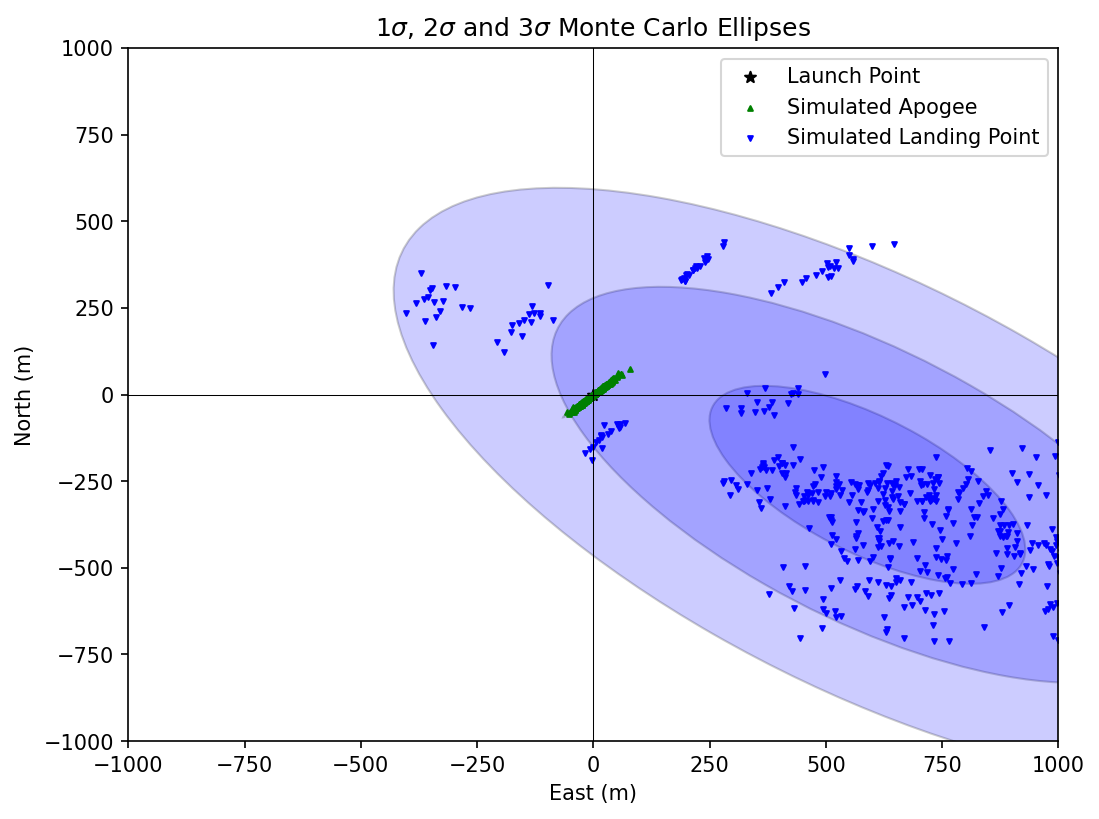

In [57]:
test_dispersion.plots.ellipses(xlim=(-1000, 1000), ylim=(-1000, 1000))

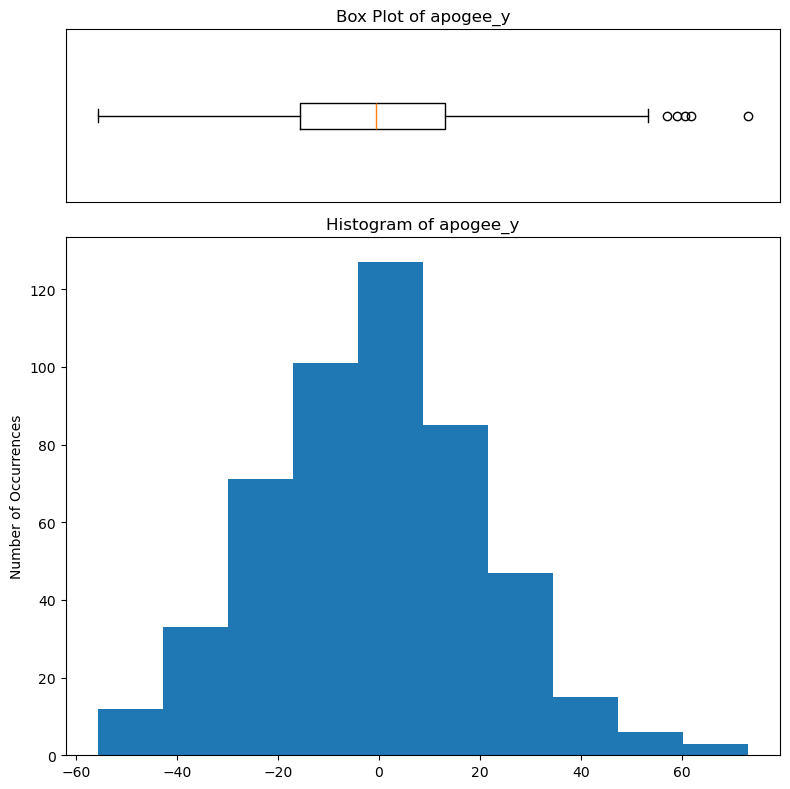

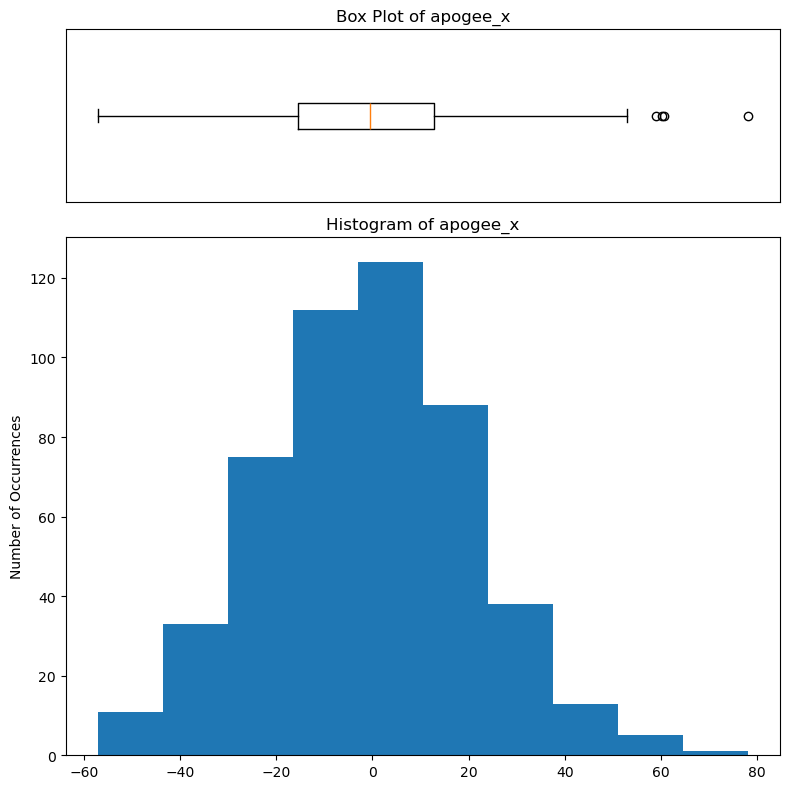

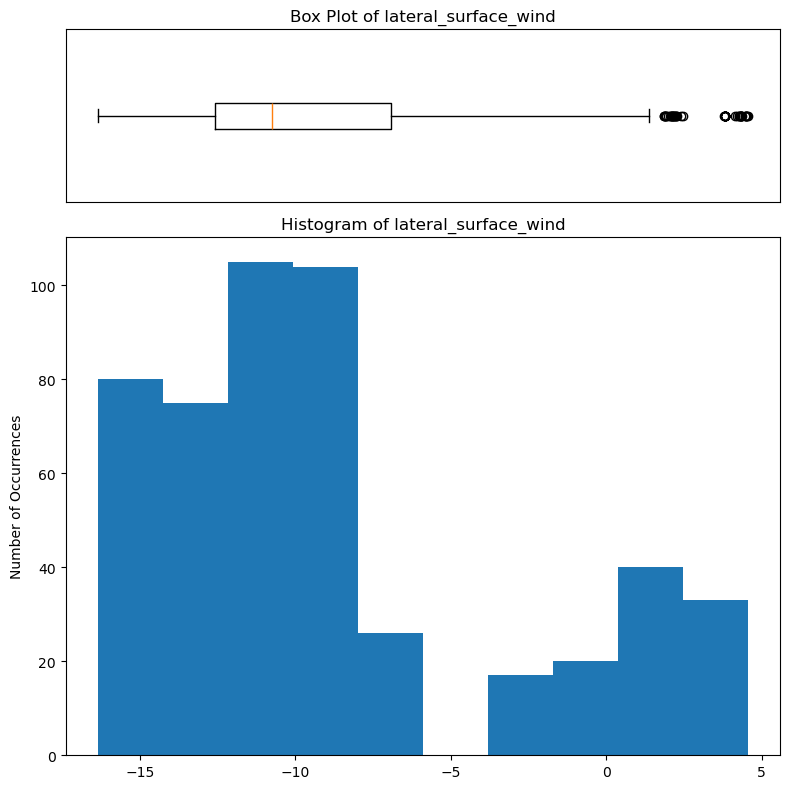

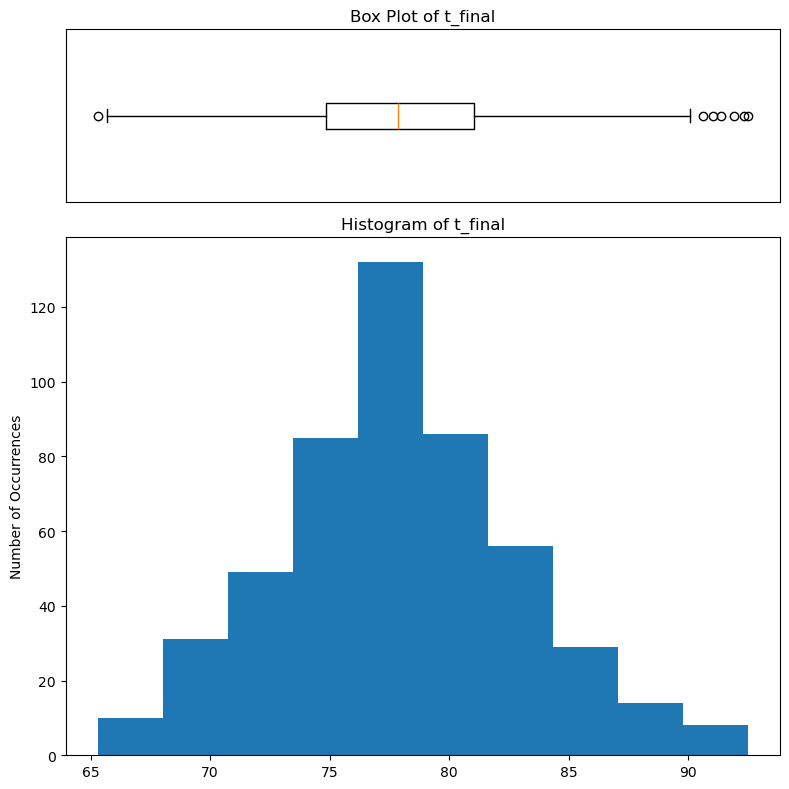

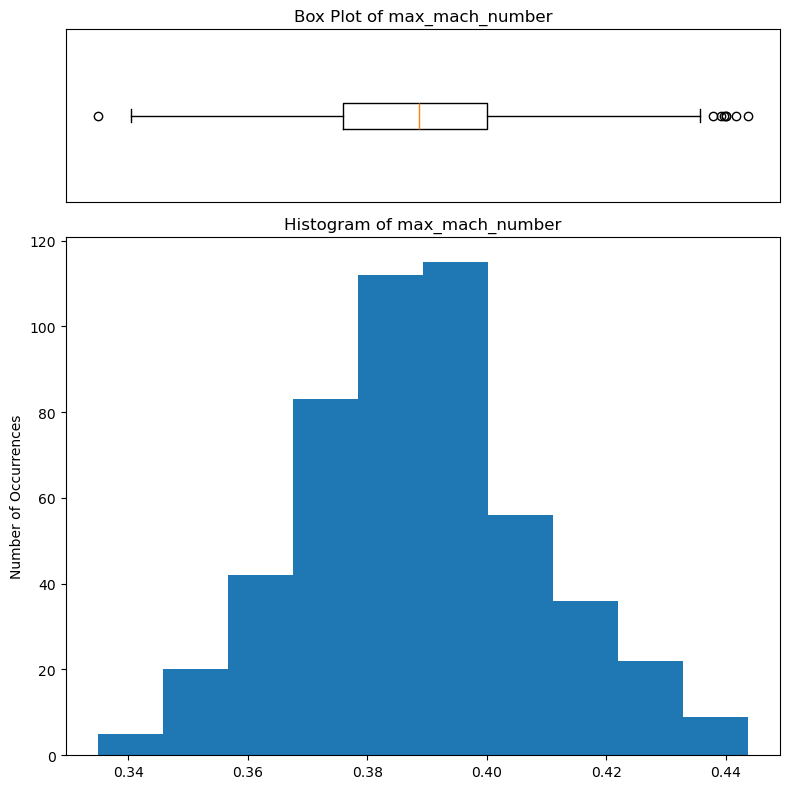

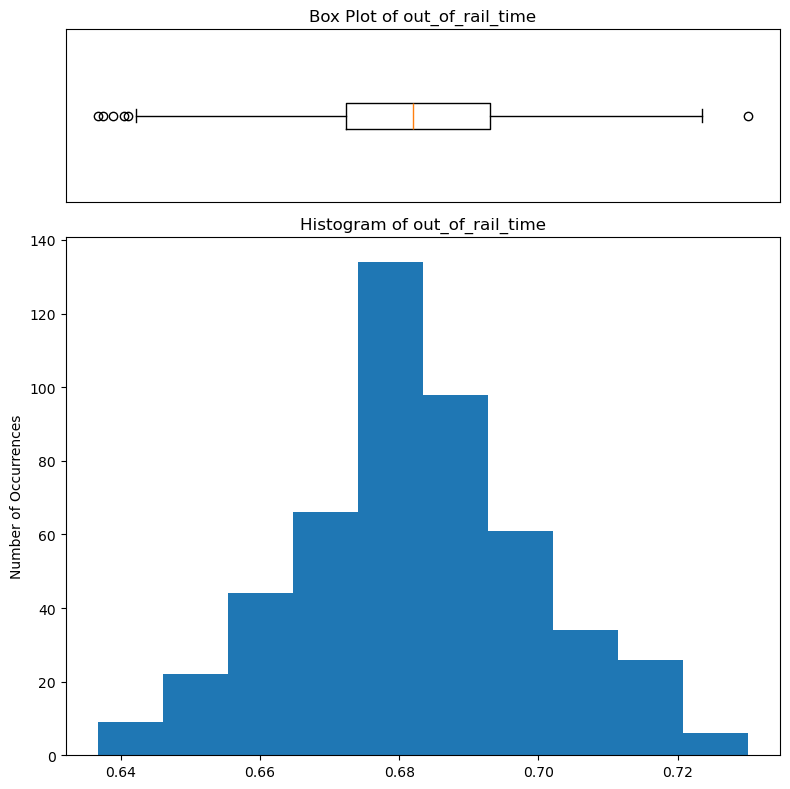

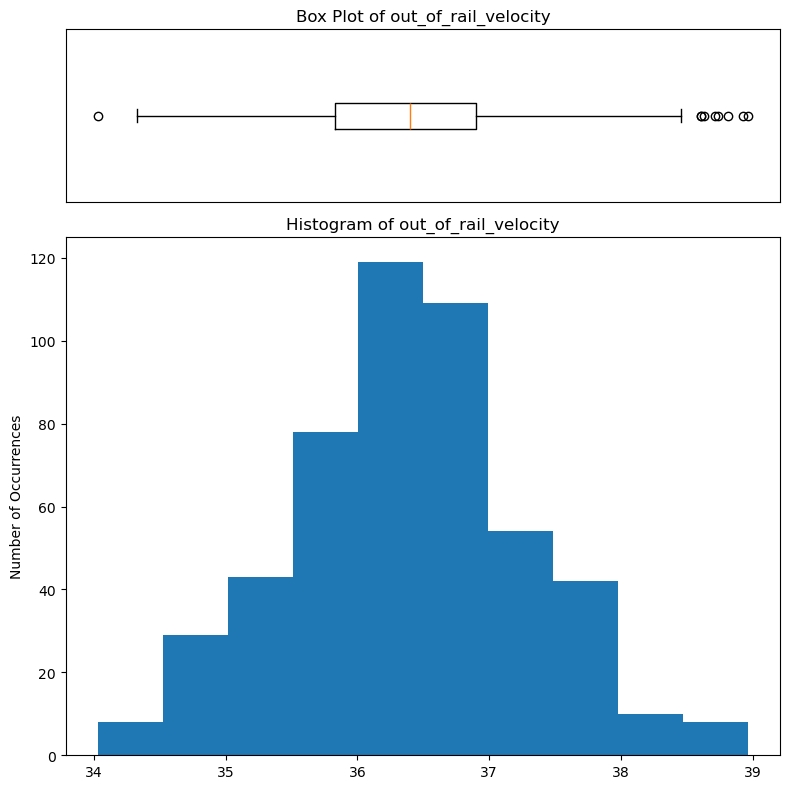

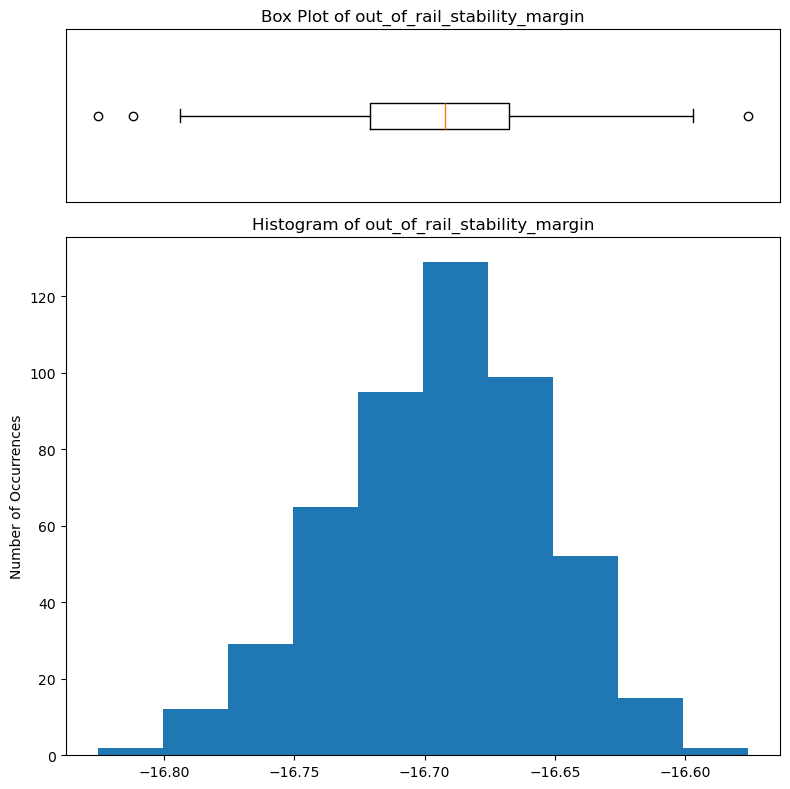

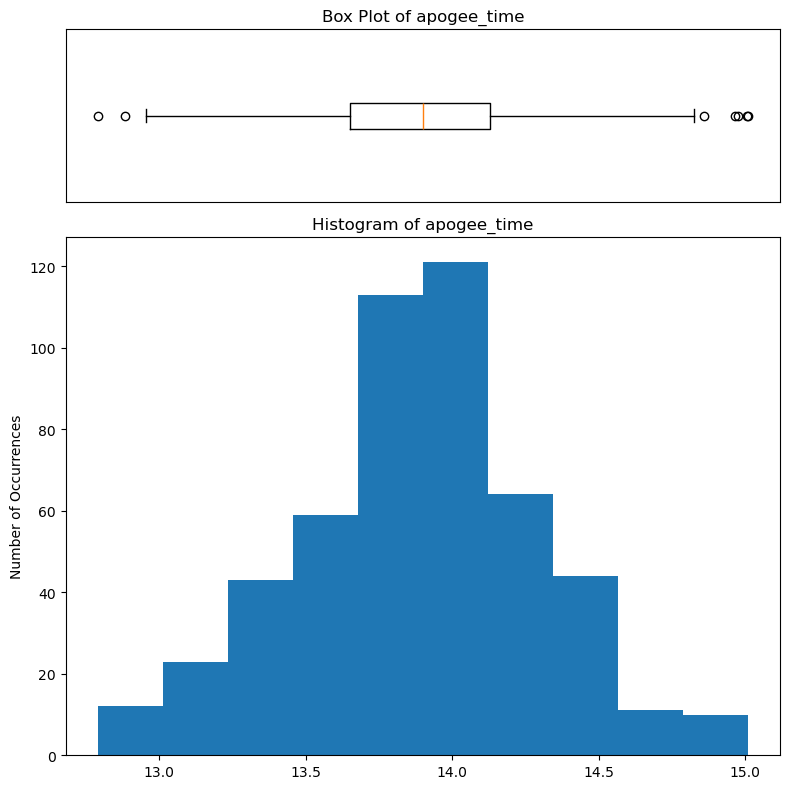

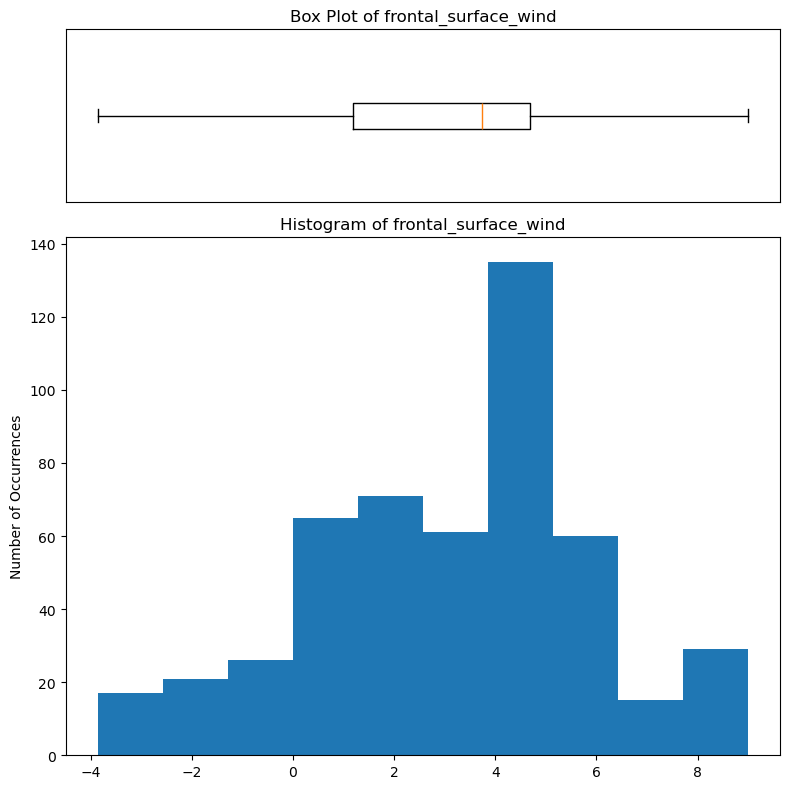

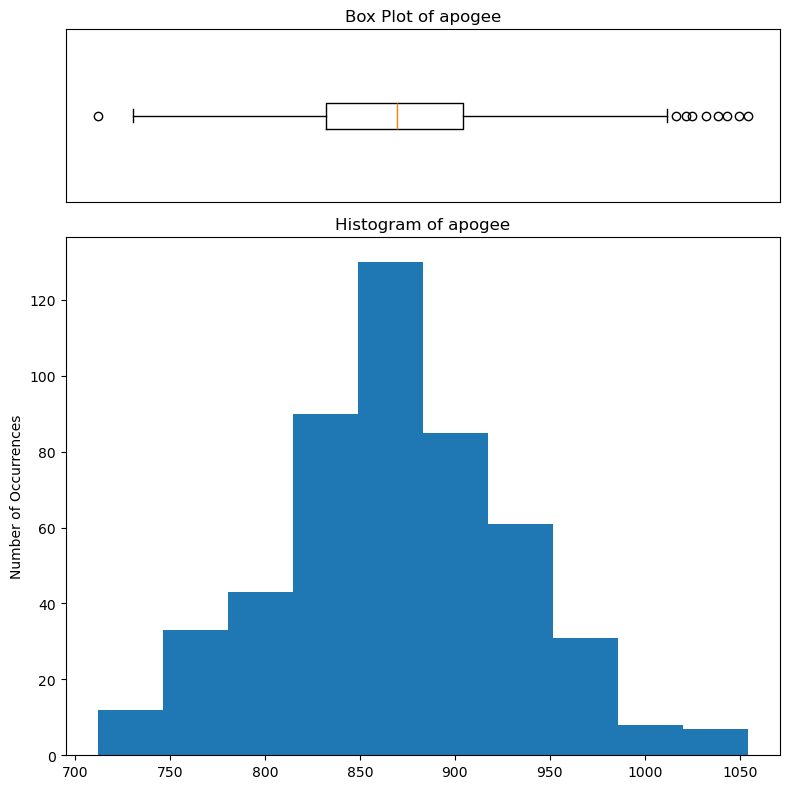

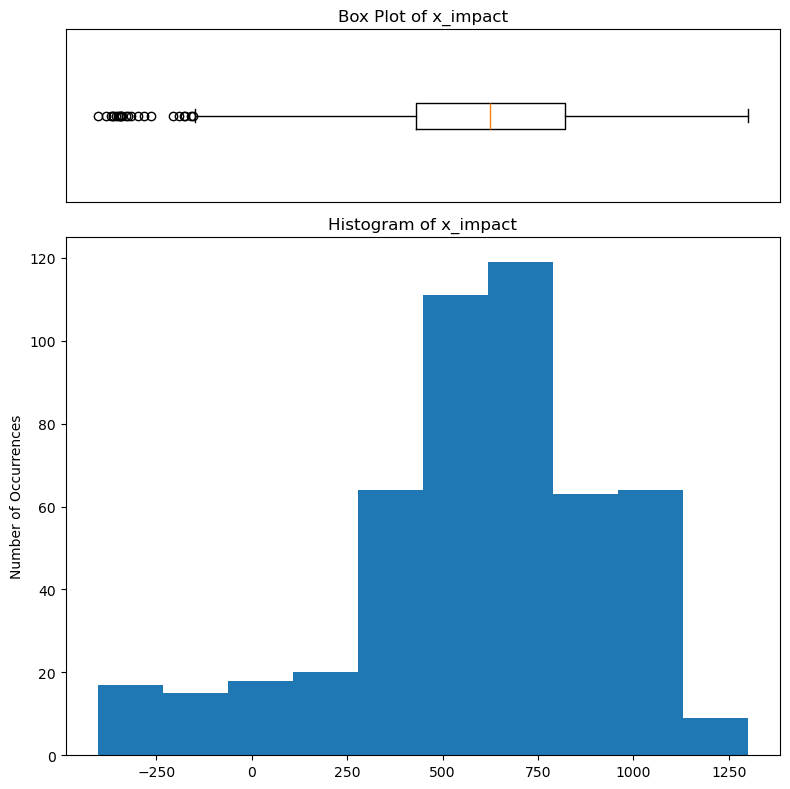

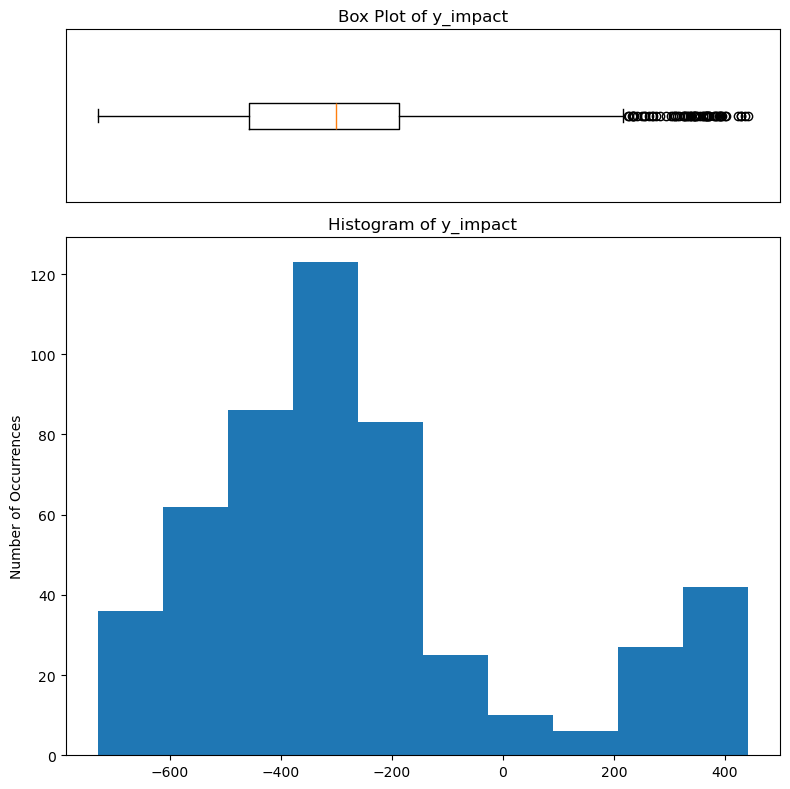

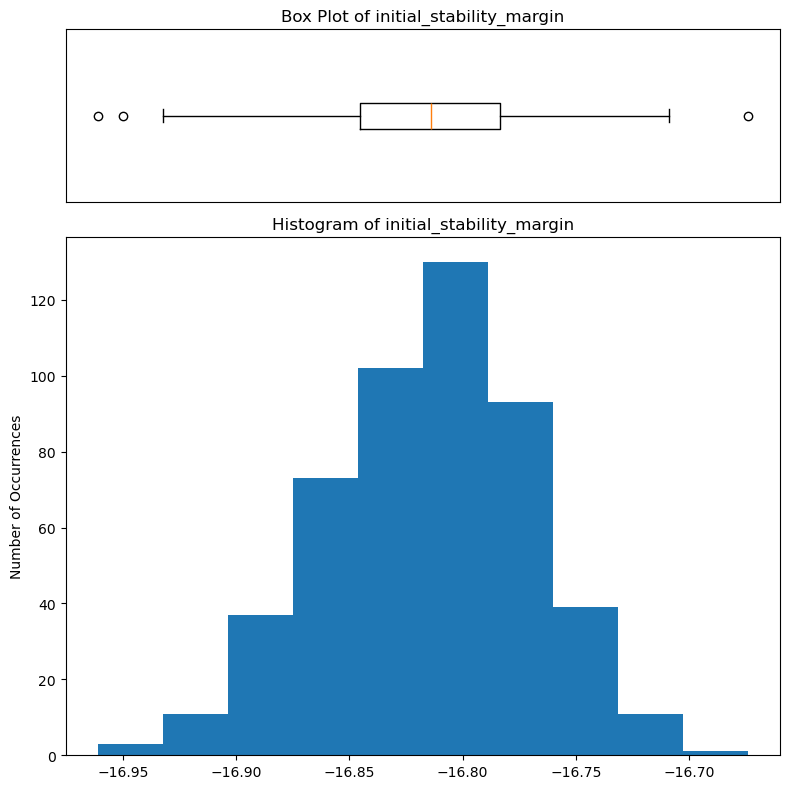

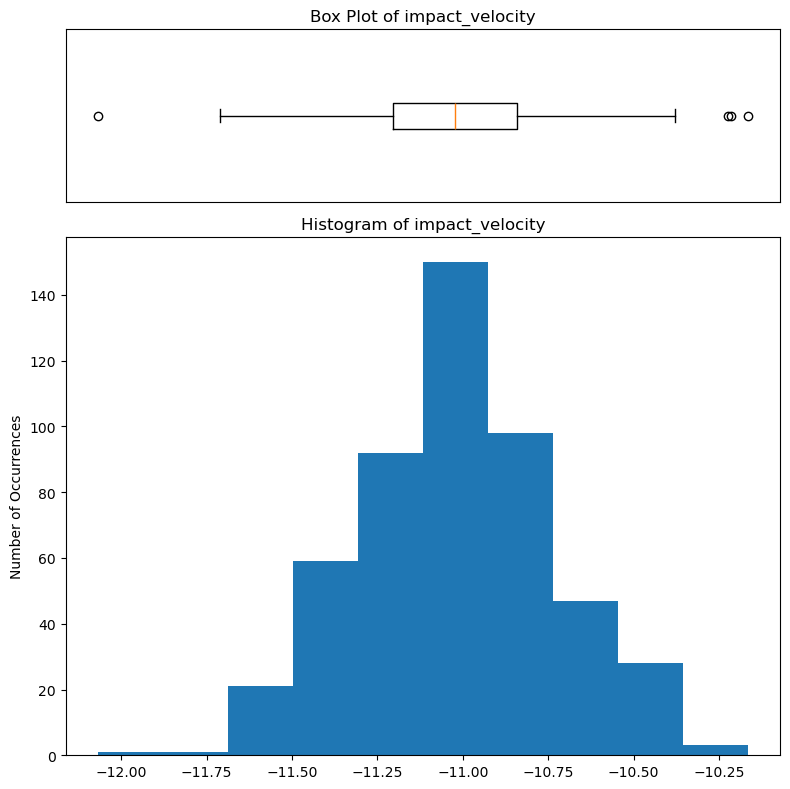

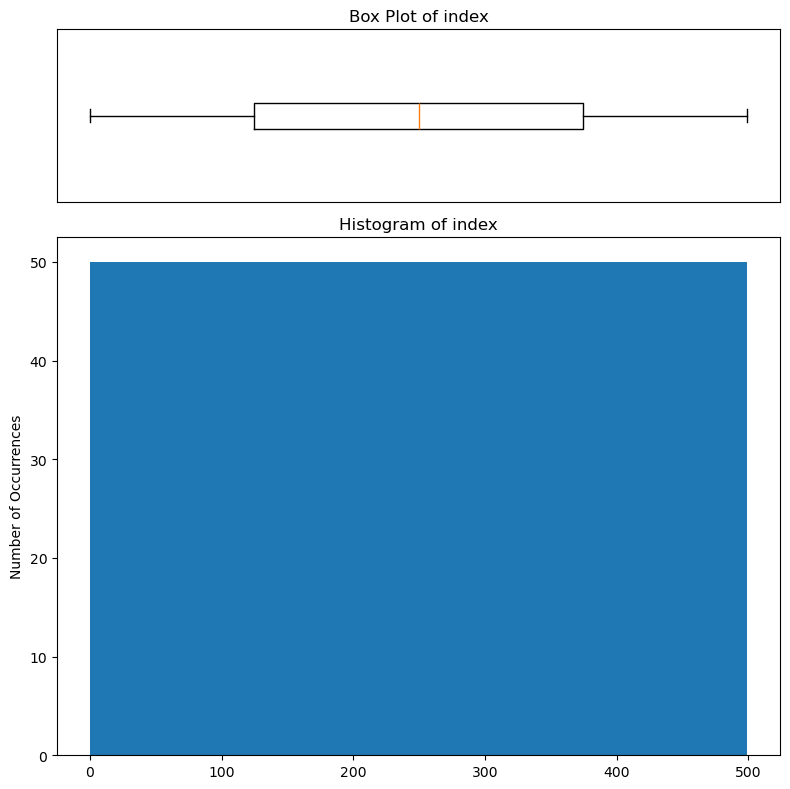

In [58]:
test_dispersion.plots.all()

In [59]:
test_dispersion.export_ellipses_to_kml(
    filename="FinnMcMissile_monte_carlo.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
)